# Summary

This is a replication and extension of work done by [Yu et. al. 2015](https://cseweb.ucsd.edu/~jmcauley/cse255/reports/fa15/017.pdf) for 
"Restaurants Review Star Prediction for Yelp Dataset". They use the following models:

1. Baseline
1. Linear Regression
1. Random Forest Regression
1. Latent Factor Model

Each of these models is compared for accuracy. They are trying to predict
'the rating of new reviews'. 

## References:

* [Yu et. al. 2015](https://cseweb.ucsd.edu/~jmcauley/cse255/reports/fa15/017.pdf)


# Dependencies

In [4]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from textblob import TextBlob

%matplotlib inline

# Data

Review data is the most interested dataset part and included
more information. Therefore, we are planning to
predict the star of a review will give. The restaurant review
dataset contains 990627 reviews (63% of total reviews),
which amounts to around 1GB of data. (*Section 2.4*)

In [2]:
reviews = pd.read_csv("data/yelp_review.csv")

Our dataset contains about 5$\times$ more reviews than the replication paper.

In [3]:
reviews.shape

(5261668, 9)

In [4]:
reviews.isna().describe()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
count,5261668,5261668,5261668,5261668,5261668,5261668,5261668,5261668,5261668
unique,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False
freq,5261668,5261668,5261668,5261668,5261668,5261668,5261668,5261668,5261668


## Training and Test sets

In [5]:
X = reviews[['review_id', 'user_id', 'business_id', 'date', 'text', 'useful', 'funny', 'cool']]
y = reviews[['stars']]

In [6]:
# Split the data into a training set using balanced classes
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

**Caveat:** Paper assumes that all reviewers in training
set also exist in the test set. Reducing training
and test set to meet this specification.

In [7]:

X_train_users = set(X_train['user_id'].values.tolist())
print("Number of users in training set: {}".format(len(X_train_users)))

X_test_users = set(X_test['user_id'].values.tolist())
print("Number of users in test set: {}".format(len(X_test_users)))

X_users = X_train_users & X_test_users
print("Number of users in the training and test set: {}".format(len(X_users)))

Number of users in training set: 1002207
Number of users in test set: 787769
Number of users in the training and test set: 463875


In [8]:
X_train_filter = X_train.user_id.apply(lambda x: True if x in X_users else False)
X_test_filter = X_test.user_id.apply(lambda x: True if x in X_users else False)

In [9]:
X_train_spec = X_train[X_train_filter]
y_train_spec = y_train[X_train_filter]

X_train_spec.shape

(2435662, 8)

In [10]:
X_test_spec = X_test[X_test_filter]
y_test_spec = y_test[X_test_filter]

X_test_spec.shape

(1723512, 8)

# Descriptive Statistics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a884a2080>]],
      dtype=object)

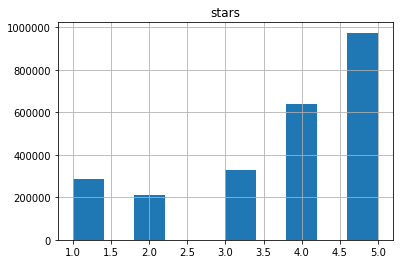

In [11]:
y_train_spec.hist()

Reviews are skewed towards 4 and 5 stars like Yu et. al. but
there are more one star ratings in our `reviews` dataset.

In [12]:
y_train_spec['stars'].value_counts()

5    975202
4    638366
3    327123
1    284140
2    210831
Name: stars, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0c0177b8>]],
      dtype=object)

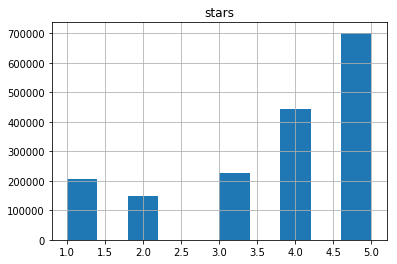

In [13]:
y_test_spec.hist()

In [14]:
y_test_spec['stars'].value_counts()

5    701934
4    442020
3    225816
1    205634
2    148108
Name: stars, dtype: int64

# Replication of Models

Replicating model from Yu et. al. 

## Evaluation Metric

In the traditional rating prediction problem, we try to
make our prediction $\hat{R}_{u,i}$ for user $u$ and
item $i$ to be as close as $R_{u,i}$, the rating user 
gives. Usually, Mean Squared Error (MSE) is employed to 
compare the performance of the different models.

$MSE = \frac{1}{|T|}\sum{(R_{u,i} - \hat{R}_{u,i})^2}$

(*Section 3*)

## Features

The features are: the average
rating stars for each user based on the review stars of the
training dataset (uRate); the average rating stars for each
business based on the review stars of the training dataset
(bRate); the count of reviews this user had made (rCount);
the lengh of the review text (tlen); the polarity of the sentiment
of the review text (tpol); the subjectivity of the sentiment
of the review text (tsub); the average rating stars for
each user which can be get from dataset directly (uAvg);
the average rating stars for each business which can be get
from dataset directly (bAvg). (*Section 4*)

In [15]:
# uRate (train)

ok = reviews[['stars', 'review_id']]
ok2 = pd.merge(ok, X_train_spec, how='inner')
feature1 = ok2[['user_id','stars']].groupby('user_id').mean()

feature1.columns = ['uRate']

X_train_spec = pd.merge(X_train_spec, feature1, how='outer', on='user_id')
X_train_spec.shape

(2435662, 9)

In [ ]:
# uRate (test)

ok3 = pd.merge(ok, X_test_spec, how='inner')
feature1t = ok3[['user_id', 'stars']].groupby('user_id').mean()

feature1t.columns = ['uRate']

X_test_spec = pd.merge(X_test_spec, feature1t, how='outer', on='user_id')
X_test_spec.shape

In [16]:
# bRate (train)

feature2 = ok2[['business_id', 'stars']].groupby('business_id').mean()
feature2.columns = ['bRate']

X_train_spec = pd.merge(X_train_spec, feature2, how='outer', on='business_id')
X_train_spec.shape

(2435662, 10)

In [ ]:
# bRate (test)

feature2t = ok3[['business_id', 'stars']].groupby('business_id').mean()
feature2t.columns = ['bRate']

X_test_spec = pd.merge(X_test_spec, feature2t, how='outer', on='business_id')
X_test_spec.shape

In [17]:
# rCount (train)

feature3 = X_train_spec.user_id.value_counts()
feature3 = pd.DataFrame(feature3)

feature3.columns = ['rCount']
feature3['user_id'] = feature3.index

X_train_spec = pd.merge(X_train_spec, feature3, how='outer', on='user_id')

In [ ]:
# rCount (test)

feature3t = X_test_spec.user_id.value_counts()
feature3t = pd.DataFrame(feature3t)

feature3t.columns = ['rCount']
feature3t['user_id'] = feature3t.index

X_test_spec = pd.merge(X_test_spec, feature3t, how='outer', on='user_id')

In [18]:
# tlen (train)

X_train_spec['tlen'] = X_train_spec.text.apply(lambda x: len(x))

In [ ]:
# tlen (test)

X_test_spec['tlen'] = X_test_spec.text.apply(lambda x: len(x))

The python library TextBlob is used in this project. It’s
a library help processing textual data and provides the API
for natural language processing. For the sentiment analysis
tasks, TextBlob returns a named tuple with float variables
polarity and subjectivity.

The polarity score is a float number in range of [-1.0, 1.0].
The more positive the value is, the more positive the input
text is. Vice versa the more negative input text leads to the
more negative value of polarity score.

For example, the negative text may include the words like:
’hate’, ’disappointed’, ’dislike’, ’annoyed’, ’awful’, etc. The
positive text may include the words like: ’excellent’, ’great’,
’best’, etc.

The subjectivity score is also a float number but in range
of [0.0, 1.0]. The 0.0 indicates the most objective score and
1.0 indicates the most subjective score.
For example, the subjective text may have a high frequency
of the word like: ’I’, ’we’, ’our’, etc. The objective
text may have a really low frequency of those words.

(*Section 6.2*)

In [50]:
# Compute sentiment at once because it takes awhile (train)

def get_sentiment(x: str):
    """ Compute polarity using text blob. """
    blob = TextBlob(x)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    return (polarity, subjectivity)

X_train_spec['sentiment'] = X_train_spec.text.apply(lambda x: get_sentiment(x))

In [ ]:
# Compute sentiment at once because it takes awhile (test)

X_test_spec['sentiment'] = X_test_spec.text.apply(lambda x: get_sentiment(x))

In [57]:
# tpol (train)

X_train_spec['tpol'] = X_train_spec.sentiment.apply(lambda x: x[0])

In [ ]:
# tpol (test)

X_test_spec['tpol'] = X_test_spec.sentiment.apply(lambda x: x[0])

In [58]:
# tsub (train)

X_train_spec['tsub'] = X_train_spec.sentiment.apply(lambda x: x[1])

In [ ]:
# tsub (test)

X_test_spec['tsub'] = X_test_spec.sentiment.apply(lambda x: x[1])

In [114]:
# uAvg (train)

feature6 = reviews[['user_id','stars']].groupby('user_id').mean()
feature6.columns = ['uAvg']

X_train_spec = pd.merge(X_train_spec, feature6, how='left', on='user_id')

In [ ]:
# uAvg (test)

X_test_spec = pd.merge(X_test_spec, feature6, how='left', on='user_id')

In [115]:
# bAvg (train)

feature7 = reviews[['business_id', 'stars']].groupby('business_id').mean()
feature7.columns = ['bAvg']

X_train_spec = pd.merge(X_train_spec, feature7, how='left', on='business_id')

In [ ]:
# bAvg (test)

X_test_spec = pd.merge(X_test_spec, feature7, how='left', on='business_id')

In [117]:
X_train_spec.columns

Index(['review_id', 'user_id', 'business_id', 'date', 'text', 'useful',
       'funny', 'cool', 'uRate', 'bRate', 'rCount', 'tlen', 'sentiment',
       'tpol', 'tsub', 'uAvg', 'bAvg'],
      dtype='object')

In [ ]:
X_test_spec.columns

In [ ]:
# Cache features

X_test_spec.to_csv("X_test_spec.csv")
y_test_spec.to_csv("y_test_spec.csv")
X_train_spec.to_csv("X_train_spec.csv")
y_train_spec.to_csv("y_train_spec.csv")

## 1. Baseline

The baseline model is straightforward, using user’s previous
average given star to predict their future reviews’ star.
That is, based on the training data, a average star for each
user is computed by computing the average of all their previous
review stars. Then, we used these averages to predict
test dataset. When a user in test dataset has not been seen
before, we will use the global average star instead of it. (*Section 4.1*)

In [23]:
# Compute baseline average stars feature

ok = reviews[['stars', 'review_id']]
ok2 = pd.merge(ok, X_train_spec, how='outer')

In [24]:
feature1 = ok2[['user_id','stars']].groupby('user_id').mean()
feature1.head()

,stars
user_id,
---1lKK3aKOuomHnwAkAow,4.164384
---udAKDsn0yQXmzbWQNSw,5.000000
--0kuuLmuYBe3Rmu0Iycww,3.000000
--104qdWvE99vaoIsj9ZJQ,3.000000
--1av6NdbEbMiuBr7Aup9A,3.666667


In [25]:
pred = pd.merge(X_train_spec, feature1, on='user_id', how='left')
pred.shape

(2435662, 13)

In [26]:
pred_test = pd.merge(X_test_spec, feature1, on='user_id', how='left')
pred_test.shape

(1723512, 9)

### Evaluate Model 1

In [27]:
train_score = mean_squared_error(y_train_spec, pred['stars'])

In [28]:
test_score = mean_squared_error(y_test_spec, pred_test['stars'])

In [29]:
print("MSE training score, '{}', and test score '{}'.".format(round(train_score, 2), round(test_score, 2)))

MSE training score, '2.5', and test score '2.1'.


## 2. Linear Regression

With the features mentioned above in this part, we applied
the linear regression to the training dataset. The features
are rCount, tlen, tpol, tsub. The label is set to (review_star - (uAvg+bAvg)/2.0) 
where $y_i$ is review $star_i$ and $\epsilon_i$ is
(uAvg+bAvg)/2.0. With the features and labels, the linear
regression is applied by using numpy.linalg.lstsq.
Then, the (features·θ+(uAvg+bAvg)/2.0) is applied, which
is the equation mentioned above, to do the prediction for
those users and businesses seen in training dataset. Otherwise,
use (feature·θ+averageRate) for prediction where averageRate
is the average rating stars for all training reviews.
Furthermore, in this model, we also add a correction to
set the prediction value equal to 5.0 if it’s calculated value
is larger than 5.0, since the rating stars will never be larger
than 5.0.

In [1]:
# Compute features

X_train_reg = X_train_spec[['rCount', 'tlen', 'tpol', 'tsub']]
y_train_reg = y_train_spec - (X_train_spec.uAvg + X_train_spec.bAvg)/2.0

NameError: name 'X_train_spec' is not defined

In [5]:
# Compute model

#m = np.linalg.lstsq(X_train_reg, y_train_reg)
# use scikit-learn instead of numpy